# Baseline models and simple strategies
### Goals: 
- Constructing a Geomtric Brownian Motion baseline,
- Implementing two simple models (momentum, mean-reversion), 
- Using minimal backtest and plots

### Outputs:
- Simulated GBM paths calibrated to historical μ, σ
- Two simple strategies (momentum and z-score mean-reversion)
- Minimal chronological backtester with fees & slippage
- Standard performance metrics and plots

The asset price $S_t$ is assumed to follow a stochastic differential equation (SDE):

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

where:
- $\mu$ = drift (expected return),
- $\sigma$ = volatility,
- $W_t$ = standard Brownian motion.

Solution:

$$
S_t = S_0 \exp\left( \Big(\mu - \tfrac{1}{2}\sigma^2\Big) t + \sigma W_t \right).
$$

Thus log-returns are normally distributed:

$$
\ln \frac{S_t}{S_0} \sim \mathcal{N}\Big( (\mu - \tfrac{1}{2}\sigma^2)t, \; \sigma^2 t \Big).
$$




#### Daily log returns
Given prices $\{ P_t \}$, daily log returns are:

$$
r_t = \ln \left( \frac{P_t}{P_{t-1}} \right).
$$

#### Unbiased sample mean and standard deviation (daily):

$$
\bar{r}_{\text{daily}} = \frac{1}{T} \sum_{t=1}^T r_t, 
\quad
\sigma_{\text{daily}} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r}_{\text{daily}})^2}.
$$




## Imports & load data

In [44]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path



# Get current notebook's folder
notebook_dir = Path().resolve()

# Walk up until we hit "2025model_project"
project_root = notebook_dir
while project_root.name != "2025model_project" and project_root != project_root.parent:
    project_root = project_root.parent

data_path = project_root / "data" / "processed" / "prices.csv"

prices = pd.read_csv(data_path, index_col=0, parse_dates = True)
prices = prices.sort_index()
prices.head()


,AAPL,MSFT,AMZN,GOOG,NVDA,META,TSLA,JNJ,JPM,XOM
Date,,,,,,,,,,
2018-01-02,40.380993,79.198334,59.450500,52.888073,4.928807,180.430130,21.368668,112.060028,87.152023,59.486649
2018-01-03,40.373962,79.566910,60.209999,53.756134,5.253191,183.662415,21.150000,113.130486,87.240829,60.654999
2018-01-04,40.561493,80.267220,60.479500,53.950798,5.280882,183.324249,20.974667,113.122459,88.490616,60.738953
2018-01-05,41.023300,81.262375,61.457001,54.736923,5.325634,185.830536,21.105333,114.056053,87.922516,60.689980
2018-01-08,40.870941,81.345306,62.343498,54.970821,5.488815,187.252731,22.427334,114.200958,88.052368,60.962818


## Defining functions for metrics

In [45]:
# defining functions for metrics
def annualize_return(returns, periods_per_year=252):
    mean_daily = np.nanmean(returns)
    return (1 + mean_daily ** periods_per_year) - 1

def annualize_vol(returns, periods_per_year=252):
    return np.nanstd(returns) * np.sqrt(periods_per_year)

def sharpe_ratio(returns, rf = 0.0, periods_per_year = 252):
    ann_ret = annualize_return(returns, periods_per_year)
    ann_vol = annualize_vol(returns, periods_per_year)
    if ann_vol == 0:
        return np.nan
    return (ann_ret - rf)/ann_vol

def max_drawdown(nav_series):
    cum_max = np.maximum.accumulate(nav_series)
    drawdown = (nav_series - cum_max)/cum_max
    return drawdown.min()

def compute_turnover(trades_ledger, nav):
    turnover = np.sum(trades_ledger) / np.sum(nav)
    return 

# Cell 3: GBM simulate function
def gbm_simulate(S0, mu, sigma, days=252, n_paths=1000, seed=None):
    rng = np.random.default_rng(seed)
    dt = 1/252
    # increments are daily log-returns (Δ ln S)
    increments = rng.normal((mu - 0.5 * sigma**2) * dt,
                            sigma * np.sqrt(dt),
                            size=(days, n_paths))
    # cumulative log returns
    log_paths = np.cumsum(increments, axis=0)
    # convert to price paths, prepend S0
    paths = S0 * np.exp(log_paths)
    paths = np.vstack([np.full((1, n_paths), S0), paths])  # shape = (days+1, n_paths)
    return paths








## Calibrate GBM (annual mean and volatility) from historical log returns

In [46]:
# Compute daily log returns and calibrate mu, sigma (annualised)
rets = np.log(prices / prices.shift(1))

# choosing an asset to demonstrate as baseline
asset = "AAPL"
r = rets[asset]
trading_days = 252
mean_daily = r.mean()
std_daily = r.std(ddof=1)


# annualised
mu_hat = mean_daily * trading_days + 0.5 * (std_daily**2) * trading_days  # MLE drift for GBM (optional +0.5 sigma^2 correction)
# alternative common estimator (sample mean *252)
mu_hat_alt = mean_daily * trading_days
sigma_hat = std_daily * np.sqrt(trading_days)

print(f"Calibrated for {asset}: mu_hat={mu_hat:.4f}, sigma_hat={sigma_hat:.4f} (annual)")
print(f"(alt mu={mu_hat_alt:.4f})")

Calibrated for AAPL: mu_hat=0.3074, sigma_hat=0.3055 (annual)
(alt mu=0.2608)


## Simulate GBM paths and plot percentiles



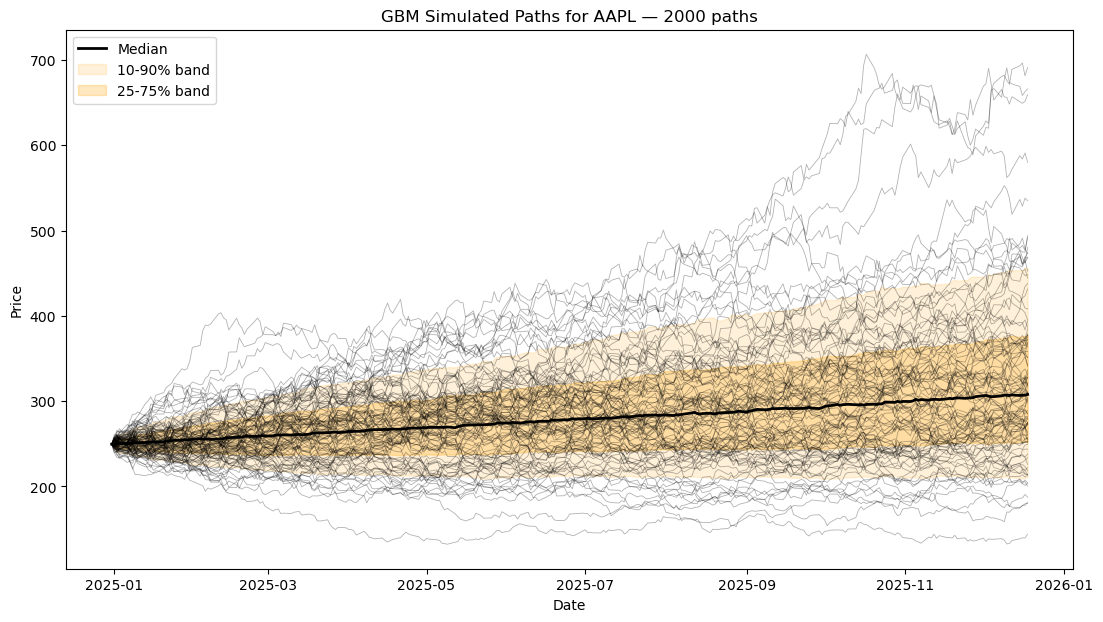

In [47]:
S0 = prices[asset].iloc[-1] # start model from last observed price
mu_sim = mu_hat_alt
sigma_sim = sigma_hat

n_days = 252
n_paths = 2000

paths = gbm_simulate(S0, mu_sim, sigma_sim, days=n_days, n_paths=n_paths, seed = 123)
time_index = pd.date_range(start=prices.index[-1], periods = n_days+1, freq='B') # business day index

paths_df = pd.DataFrame(paths, index=time_index)


# percentiles at each time point
p10 = paths_df.quantile(0.10, axis=1)
p25 = paths_df.quantile(0.25, axis=1)
p50 = paths_df.quantile(0.50, axis=1)
p75 = paths_df.quantile(0.75, axis=1)
p90 = paths_df.quantile(0.90, axis=1)



plt.figure(figsize=(13, 7))
# plot sample few paths
for i in range(100):
    plt.plot(paths_df.index, paths_df.iloc[:, i], color='black', alpha=0.3, linewidth=0.6)
plt.plot(p50.index, p50, label='Median', color='black', linewidth=2)
plt.fill_between(p10.index, p10, p90, color='orange', alpha=0.15, label='10-90% band')
plt.fill_between(p25.index, p25, p75, color='orange', alpha=0.25, label='25-75% band')
plt.title(f"GBM Simulated Paths for {asset} — {n_paths} paths")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.show()

### Implementing two signals: 20/60 MA momentum and z-score mean-reversion
- Momentum signal: long = 1 when 20 signal > 60 signal, else 0 (flat)
Shift +1 to avoid look-ahead bias

- Z-score mean reversion
Define thresholds: short  (z > +2), long (z < -2).





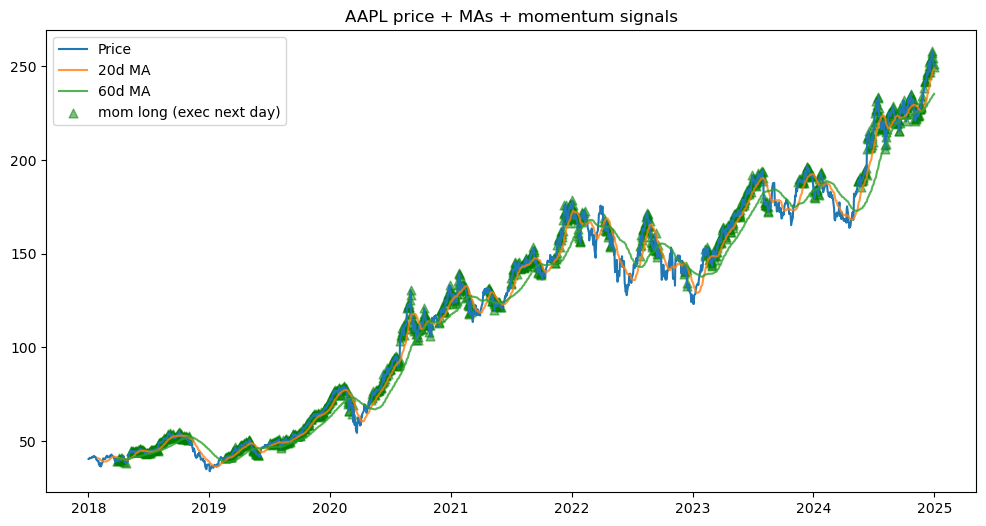

In [48]:
# MA and z-score signals
look_short = 20
look_long = 60
z_look = 20

price_series = prices[asset].copy()

# moving averages
ma_short = price_series.rolling(window=look_short).mean()
ma_long = price_series.rolling(window=look_long).mean()

# momentum signal: long=1 when short>long, else 0 (flat), shift +1 to avoid look-ahead
mom_signal = (ma_short > ma_long).astype(int).shift(1).fillna(0)

# z-score mean reversion (on price or on log-price; more common on spread or returns)
rolling_mean = price_series.rolling(window=z_look).mean()
rolling_std = price_series.rolling(window=z_look).std(ddof=0)
zscore = (price_series - rolling_mean) / rolling_std

# define thresholds: if z > +2 -> short, z < -2 -> long. We'll implement as +1/-1 positions.
mr_signal = pd.Series(0, index=price_series.index)
mr_signal[zscore.shift(1) < -2] = 1    # long when yesterday z < -2 (shift to avoid lookahead)
mr_signal[zscore.shift(1) >  2] = -1   # short when yesterday z > 2

# optional: convert mr_signal to 0/1 long-only by setting negative to 0
# mr_signal_longonly = mr_signal.clip(lower=0)

# quick plot signals
plt.figure(figsize=(12,6))
plt.plot(price_series.index, price_series, label='Price')
plt.plot(ma_short.index, ma_short, label=f'{look_short}d MA', alpha=0.8)
plt.plot(ma_long.index, ma_long, label=f'{look_long}d MA', alpha=0.8)
plt.scatter(price_series.index[mom_signal==1], price_series[mom_signal==1], marker='^', color='g', s=40, alpha = 0.5, label='mom long (exec next day)')
plt.title(f"{asset} price + MAs + momentum signals")
plt.legend(); plt.show()

In [49]:
# price: pd.Series of daily asset prices
# signal: pd.Series of target portfolio positions, between -1 and 1
# init_cash: start NAV
# fee_bps, slippage_bps: execution friction in basis points

def backtest(price, signal, init_cash = 1.0, fee_bps = 0.0, slippage_bps = 0.0):
    dates = price.index
    n = len(dates)
    nav = np.full(n, np.nan) # portfolio value over time
    pos = np.full(n, np.nan) # target position fraction each day
    holdings = np.full(n, np.nan) # exposure in the asset
    cash = np.full(n, np.nan) # uninvested cash
    trades = np.zeros(n) # absolute trade notional in each day
    
    nav[0] = init_cash
    pos[0] = 0.0
    holdings[0] = 0.0
    cash[0] = init_cash
    
    for t in range(1, n):
        prev_pos = pos[t-1]
        target_pos = float(signal.iloc[t])  # fraction in [-1, 1]
        prev_nav = nav[t-1]
        
        # compute desired exposure
        target_exposure = target_pos * prev_nav
        prev_exposure = prev_pos * prev_nav
        
        # trade notional = absolute change in exposure
        trade_notional = abs(target_exposure - prev_exposure)
        
        # fees and slippage (as fraction of trade_notional)
        cost = trade_notional * (fee_bps + slippage_bps) / 10000
        
        # update holdings and cash BEFORE price move (we assume trade executed at next open at prev price)
        holdings[t] = target_exposure
        cash[t] = prev_nav - target_exposure - cost  # subtract exposure + costs; cash may be negative if using leverage
        
        # price return from t-1 to t
        ret = (price.iloc[t] / price.iloc[t-1]) - 1.0
        
        # update NAV at t after price movement
        nav[t] = holdings[t] * (1 + ret) + cash[t]
        
        pos[t] = target_pos
        trades[t] = trade_notional
    
    results = pd.DataFrame({
        'price': price,
        'nav': nav,
        'position': pos,
        'trade_notional': trades
    }, index=dates)
    
    # turnover as sum(trade_notional) / average NAV (over period)
    total_traded = trades.sum()
    avg_nav = np.nanmean(nav)
    turnover = total_traded / avg_nav if avg_nav != 0 else np.nan
    
    results.attrs = {'turnover': turnover}
    return results


## Run backtests for momentum and mean reversion


In [50]:
# momentum: use fixed exposure 0.5 
mom_target = mom_signal.copy()
mom_fraction = mom_target * 0.5

# mean reversion: use fixed exposure 0.5
mr_fraction = mr_signal * 0.5

# run backtests
mom_results = backtest(price_series, mom_fraction, init_cash = 1.0, fee_bps = 0, slippage_bps = 0)
mr_results = backtest(price_series, mr_fraction, init_cash = 1.0, fee_bps = 0, slippage_bps = 0)

print("MOM results:\n", mom_results.round(5))
print("MR results:\n", mr_results.round(5))
print(f"MOM turnover: {mom_results.attrs['turnover']:.5f}")
print(f"MR turnover: {mr_results.attrs['turnover']:.5f}")




MOM results:
                 price      nav  position  trade_notional
Date                                                    
2018-01-02   40.38099  1.00000       0.0             0.0
2018-01-03   40.37396  1.00000       0.0             0.0
2018-01-04   40.56149  1.00000       0.0             0.0
2018-01-05   41.02330  1.00000       0.0             0.0
2018-01-08   40.87094  1.00000       0.0             0.0
...               ...      ...       ...             ...
2024-12-24  257.28668  2.21219       0.5             0.0
2024-12-26  258.10373  2.21570       0.5             0.0
2024-12-27  254.68588  2.20103       0.5             0.0
2024-12-30  251.30786  2.18643       0.5             0.0
2024-12-31  249.53416  2.17872       0.5             0.0

[1761 rows x 4 columns]
MR results:
                 price      nav  position  trade_notional
Date                                                    
2018-01-02   40.38099  1.00000       0.0             0.0
2018-01-03   40.37396  1.00000      

### Performance metrics: annualised return, volatility, Sharpe, max drawdown


In [55]:
# defining metrics helpers
def ann_return(nav_series, periods_per_year=252):
    total_ret = nav_series.iloc[-1] / nav_series.iloc[0] - 1
    years = len(nav_series) / periods_per_year
    return (1 + total_ret) ** (1/years) - 1

def ann_vol(nav_series, periods_per_year=252):
    # compute daily returns from NAV
    r = nav_series.pct_change().dropna()
    return r.std(ddof=1) * np.sqrt(periods_per_year)

def sharpe(nav_series, rf=0.0, periods_per_year=252):
    # excess returns in annualized terms using daily returns
    r = nav_series.pct_change().dropna()
    mean_excess = r.mean() * periods_per_year - rf
    vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    return mean_excess / vol if vol != 0 else np.nan

def max_dd(nav_series):
    arr = nav_series.values
    cum_max = np.maximum.accumulate(arr)
    dd = (arr - cum_max) / cum_max
    return dd.min()

for name, res in [('Momentum', mom_results), ('MeanReversion', mr_results)]:
    nav = pd.Series(res['nav'], index=res.index)
    print(name)
    print(" Annualized return:", ann_return(nav))
    print(" Annualized vol:", ann_vol(nav))
    print(" Sharpe (rf=0):", sharpe(nav))
    print(" Max drawdown:", max_dd(nav))
    print(" Turnover:", res.attrs['turnover'])
    print()

     

Momentum
 Annualized return: 0.11788387395038136
 Annualized vol: 0.11013438528569974
 Sharpe (rf=0): 1.0676059143190155
 Max drawdown: -0.10929983625028226
 Turnover: 16.902390639830866

MeanReversion
 Annualized return: 0.017917241478356605
 Annualized vol: 0.05616875919976632
 Sharpe (rf=0): 0.3441301342423051
 Max drawdown: -0.05748105311263114
 Turnover: 112.9501635314948



### plot NAVs & compare vs buy-and-hold benchmark

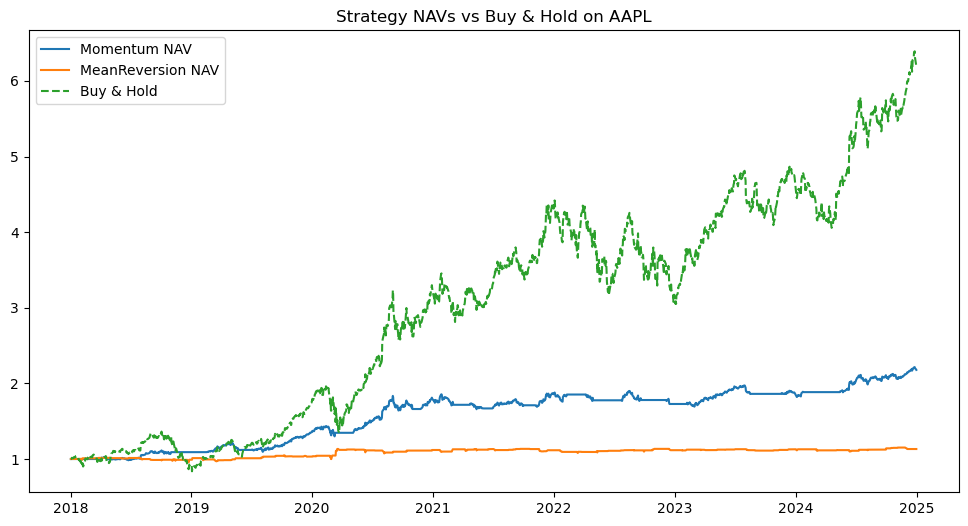

In [56]:
bh_nav = (price_series / price_series.iloc[0])  # start at 1.0

plt.figure(figsize=(12,6))
plt.plot(mom_results.index, mom_results['nav'], label='Momentum NAV')
plt.plot(mr_results.index, mr_results['nav'], label='MeanReversion NAV')
plt.plot(bh_nav.index, bh_nav.values, label='Buy & Hold', linestyle='--')
plt.legend(); plt.title(f"Strategy NAVs vs Buy & Hold on {asset}")
plt.show()